##### package install

In [ ]:
# %pip install langchain.chat_model
# %pip install langchain
# %pip install openai
# %pip install langchain_community
# %pip install pypdf
# %pip install unstructured
# %pip install python-magic-bin
# %pip install "unstructured[docx]"
# %pip install -U langchain-openai langchain-unstructured
# %pip install -U langchain-unstructured

# %pip check
# %pip list | findstr "^langchain"

# Data Loaders and Spliters

##### 문서 load

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import UnstructuredFileLoader # 다양한 확장자의 파일을 열 수 있다.

# loader0 = TextLoader("./files/chapter_one.txt")
# loader0.load()

# loader1 = PyPDFLoader("./files/chapter_one.pdf")
# loader1.load()

# 강의에서는 UnstructuredFileLoader 를 사용할 것이다.
loader = UnstructuredFileLoader("./files/chapter_one.docx")
loader.load()

##### 문서 분할
- 문서의 덩어리가 너무 크기 때문에 나눠야 한다.
    1. 답변 생성에 필요한 context를 찾기 쉽다.
    2. LLM 에게 질문과 연관된 자료를 줄 때 필요한 '파일의 부분들'만 전달할 수 있다.
    3. 그러면 Prompt 의 길이도 짧아진다. by 딱 필요한 부분만 주기 때문에

##### 이를 위해
- 문서의 모든 문자를 조각낸다.(모든 문자를 작은 조각들로 만든다.)

In [ ]:
# RecursiveCharacterTextSplitter
    # 일반적인 Text Splitter
    # 문장 혹은 문단의 끝부분마다 끊어주는(분할) 역할 --> 뜬금없이 문장의 중간을 끊지 않는다.
    # 쉽게 말해 -> 문장과 문단 구조를 유지하면서 문서를 쪼개는 것이다.
# CharacterTextSplitter
    # 지정한 문자열을 기준으로 끊을 수 있다. --> separator 속성
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

# chunk 가 작을수록 더 좋다.
splitter = RecursiveCharacterTextSplitter(
    chunk_size    = 200,# 얼마나 큰 덩어리로 쪼갤 것이냐
    chunk_overlap = 50  # 분할된 조각들의 내용을 얼마나 겹치게 할 것이냐
)

splitter2 = CharacterTextSplitter(
    separator     ="\n",# 지정한 문자열을 찾은 다음 거기서부터 끊는다.
    chunk_size    = 600,# 얼마나 큰 덩어리로 쪼갤 것이냐
    chunk_overlap = 100 # 분할된 조각들의 내용을 얼마나 겹치게 할 것이냐
)

loader = UnstructuredFileLoader("./files/chapter_one.docx")
loader.load_and_split(text_splitter=splitter2)

# Tiktoken

- 기본적으로 모든 Splitter 들은 텍스트의 length 를 계산해 한 덩어리(chunk)의 크기를 알아낸다.
- 이 과정에서 사용하는 것이 python 에서 기본으로 사용하는 len 함수이다.

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

splitter = CharacterTextSplitter(
    separator       ="\n",
    chunk_size      = 600,
    chunk_overlap   = 100,
    length_function = len
    # len 함수 외에 내가 직접 만든 커스텀 함수도 지정할 수 있다.
    # RecursiveCharacterTextSplitter 에서도 지정할 수 있다.
)

loader = UnstructuredFileLoader("./files/chapter_one.docx")
loader.load_and_split(text_splitter=splitter)

- LLM 들은 Token 을 인간과 같은 방식으로 계산하지 않는다.
- 때로는 문자 2개, 3개가 하나의 token 으로 취급 될 때가 있다.
- 즉, token과 letter(character, 문자)는 같은 의미가 아니다.

https://platform.openai.com/tokenizer
- LLM 관점에서 token 개수를 알 수 있다. -> token과 characters의 차이를 알 수 있다.
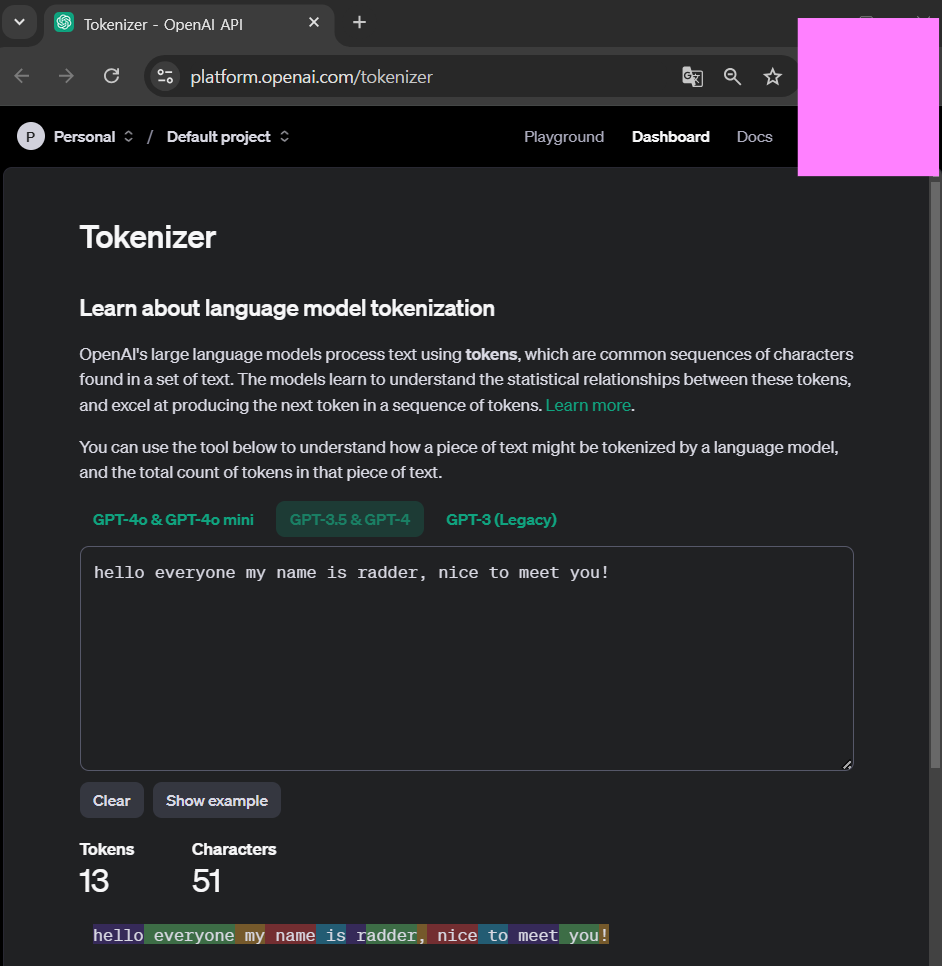
- Tokens는 13, characters는 51 이다.
- 몇 개만 예를들어 보면 LLM은
    - hello, everyone 등은 하나의 token 으로 취급한다.(공백 포함)
    - 그러나 radder는 2개의 token 으로 취급한다.(공백 포함)

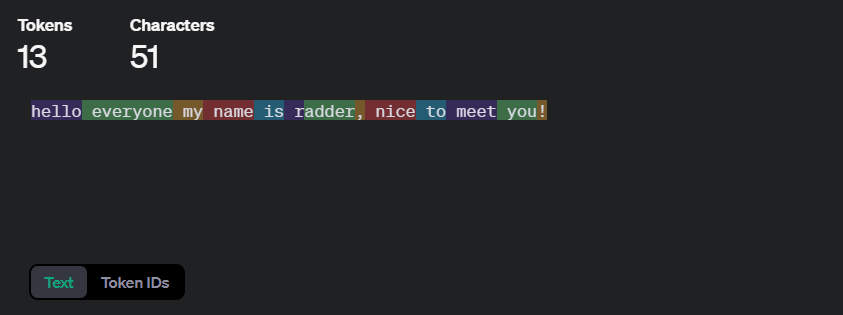
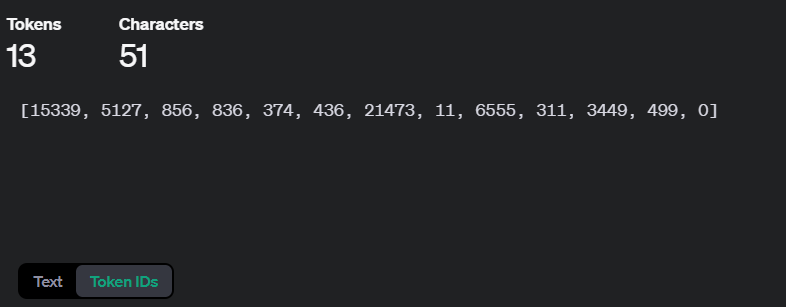
- Token IDs 가 LLM 이 실제로 보고있는 것이다.
- 내가 입력한 text가 LLM 에게는 이러한 숫자들의 묶음으로 보이는 것이다.

In [ ]:
# splitter에 위에서 설명한 token 개념을 사용할 수 있는 tokenizer(토큰화) 함수를 사용해보자
# by Python 기본 함수인 len 함수를 사용하기 싫다.

from langchain.text_splitter import CharacterTextSplitter

# from_tiktoken_encoder를 추가했다.(tiktoken은 OpenAI에서 만들었다.)
splitter = CharacterTextSplitter.from_tiktoken_encoder(
    separator     ="\n",
    chunk_size    = 600,
    chunk_overlap = 100
)

loader = UnstructuredFileLoader("./files/chapter_one.docx")
loader.load_and_split(text_splitter=splitter)

# Vectors